# Proyecto 2. Reconocimiento de Imágenes con CNN

Proyecto de visión por computadora que entrena una red neuronal convolucional (CNN) para reconocer rostros en fotos y predecir tres atributos: **edad**, **raza** y **género**.  

Incluye procesos de preprocesamiento de imágenes, división en *train/val/test* y evaluación mediante métricas específicas para cada tarea.

**Participantes**
- Daniel Sanchez Trujillo
- Sergio Paucara Saca
- Felipe Sanchez Saravia

## Bibliotecas utilizadas

In [1]:
import os
import sys
import streamlit
import numpy
import cv2
import tensorflow
import pandas
import plotly
import random

print("### Versiones utilizadas ###")
print(f"Python: {sys.version}")
print(f"Streamlit: {streamlit.__version__}")
print(f"NumPy: {numpy.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"TensorFlow: {tensorflow.__version__}")
print(f"Pandas: {pandas.__version__}")
print(f"Plotly: {plotly.__version__}")

2025-08-11 15:47:49.685421: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 15:47:49.696982: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 15:47:49.789810: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 15:47:49.865278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754941669.926118   44987 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754941669.94

### Versiones utilizadas ###
Python: 3.10.0 (default, Apr 24 2025, 12:48:49) [GCC 12.2.0]
Streamlit: 1.46.1
NumPy: 2.1.3
OpenCV: 4.11.0
TensorFlow: 2.19.0
Pandas: 2.2.3
Plotly: 6.1.2


## Analisis exploratorio de los datos

### Distribucion del dataset

In [2]:
%matplotlib inline
import os
import pandas as pd

# Definir carpeta
dataset_dir = "part1"

# Inicializar listas
age_list = []
gender_list = []
race_list = []

# Extraer datos del nombre del archivo
for file in os.listdir(dataset_dir):
    try:
        age, gender, race, _ = file.split("_", 3)
        age = int(age)
        gender = int(gender)
        race = int(race)
        age_list.append(age)
        gender_list.append(gender)
        race_list.append(race)
    except:
        continue

# Crear DataFrame
df = pd.DataFrame({
    "age": age_list,
    "gender": gender_list,
    "race": race_list
})

# Agrupar edades en intervalos de 10 años
bins = list(range(0, 121, 10))
labels = [f"{i}-{i+9}" for i in range(0, 120, 10)]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)
age_group_counts = df["age_group"].value_counts().sort_index()

# Distribución de género
gender_counts = df["gender"].map({0: "Male", 1: "Female"}).value_counts()

# Distribución de raza
race_map = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
race_counts = df["race"].map(race_map).value_counts()

# Mostrar en tablas
import IPython.display as display

print("📊 Distribución de edades (intervalos de 10 años):")
display.display(age_group_counts.to_frame("count"))

print("\n📊 Distribución de género:")
display.display(gender_counts.to_frame("count"))

print("\n📊 Distribución de raza:")
display.display(race_counts.to_frame("count"))


📊 Distribución de edades (intervalos de 10 años):


,count
age_group,
0-9,3217
10-19,1239
20-29,1524
30-39,1038
40-49,679
50-59,946
60-69,664
70-79,393
80-89,325



📊 Distribución de género:


,count
gender,
Female,5596
Male,4539



📊 Distribución de raza:


,count
race,
White,5396
Asian,1703
Indian,1493
Other,1121
Black,422


### Heatmap con la distribucion de clases

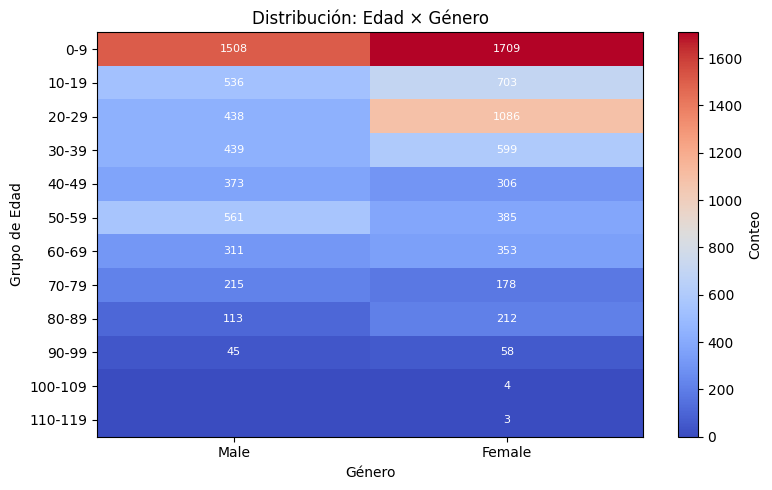

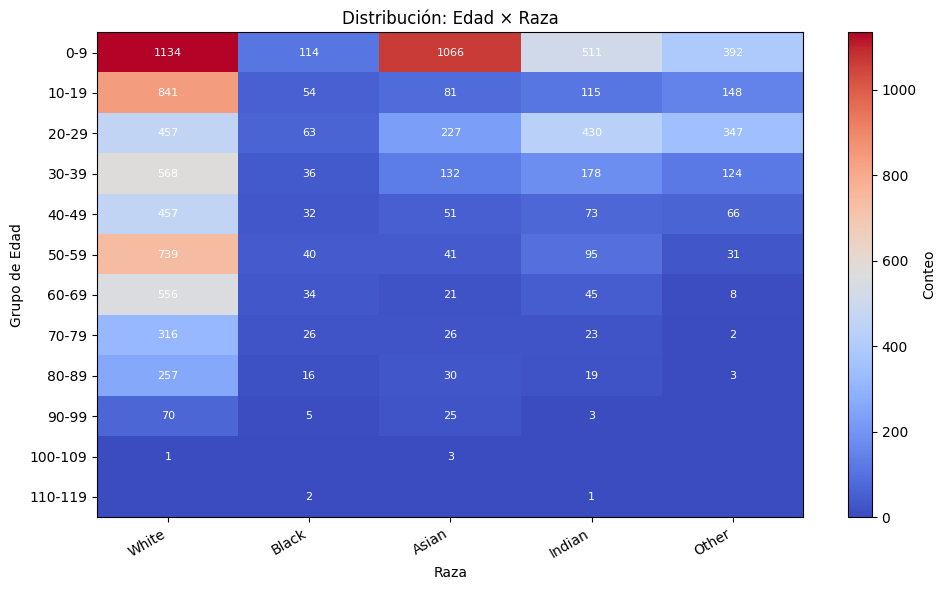

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Mapas para convertir números en etiquetas
gender_map = {0: "Male", 1: "Female"}
race_map = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}

# Crear columnas con etiquetas
df["gender_label"] = df["gender"].map(gender_map)
df["race_label"] = df["race"].map(race_map)

# Definir age_labels según tu binning previo
age_labels = [f"{i}-{i+9}" for i in range(0, 120, 10)]

# --- Heatmap 1: Edad x Género ---
ct_age_gender = pd.crosstab(df["age_group"], df["gender_label"]).reindex(
    index=age_labels, columns=["Male", "Female"]
)

plt.figure(figsize=(8, 5))
im = plt.imshow(ct_age_gender.values, aspect="auto", cmap="coolwarm")
plt.title("Distribución: Edad × Género")
plt.xlabel("Género")
plt.ylabel("Grupo de Edad")
plt.xticks(ticks=np.arange(ct_age_gender.shape[1]), labels=ct_age_gender.columns)
plt.yticks(ticks=np.arange(ct_age_gender.shape[0]), labels=ct_age_gender.index)
plt.colorbar(im, label="Conteo")
for i in range(ct_age_gender.shape[0]):
    for j in range(ct_age_gender.shape[1]):
        val = ct_age_gender.values[i, j]
        if val > 0:
            plt.text(j, i, str(val), ha="center", va="center", color="white", fontsize=8)
plt.tight_layout()
plt.show()

# --- Heatmap 2: Edad x Raza ---
race_order = ["White", "Black", "Asian", "Indian", "Other"]
ct_age_race = pd.crosstab(df["age_group"], df["race_label"]).reindex(
    index=age_labels, columns=race_order
)

plt.figure(figsize=(10, 6))
im = plt.imshow(ct_age_race.values, aspect="auto", cmap="coolwarm")
plt.title("Distribución: Edad × Raza")
plt.xlabel("Raza")
plt.ylabel("Grupo de Edad")
plt.xticks(ticks=np.arange(ct_age_race.shape[1]), labels=ct_age_race.columns, rotation=30, ha="right")
plt.yticks(ticks=np.arange(ct_age_race.shape[0]), labels=ct_age_race.index)
plt.colorbar(im, label="Conteo")
for i in range(ct_age_race.shape[0]):
    for j in range(ct_age_race.shape[1]):
        val = ct_age_race.values[i, j]
        if val > 0:
            plt.text(j, i, str(val), ha="center", va="center", color="white", fontsize=8)
plt.tight_layout()
plt.show()


## Preprocesamiento del dataset

In [4]:
import cv2
import numpy as np

def gray_world_white_balance(img):
    img = img.astype(np.float32)
    mean_b, mean_g, mean_r = img.mean(axis=(0,1))
    mean_gray = (mean_b + mean_g + mean_r) / 3.0 + 1e-6
    gain = np.array([mean_gray/mean_b, mean_gray/mean_g, mean_gray/mean_r], dtype=np.float32)
    img *= gain
    return np.clip(img, 0, 255).astype(np.uint8)

def clahe_on_luminance(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L_eq = clahe.apply(L)
    lab_eq = cv2.merge([L_eq, A, B])
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

def gamma_correction(img_bgr, gamma=1.0):
    if abs(gamma - 1.0) < 1e-3:
        return img_bgr
    inv = 1.0/gamma
    table = ((np.arange(256)/255.0)**inv * 255).astype(np.uint8)
    return cv2.LUT(img_bgr, table)


In [5]:
def letterbox_resize(img_bgr, size=224, pad_val=128):
    h, w = img_bgr.shape[:2]
    scale = size / max(h, w)
    nh, nw = int(round(h*scale)), int(round(w*scale))
    img_res = cv2.resize(img_bgr, (nw, nh), interpolation=cv2.INTER_AREA)
    canvas = np.full((size, size, 3), pad_val, dtype=np.uint8)
    top = (size - nh)//2
    left = (size - nw)//2
    canvas[top:top+nh, left:left+nw] = img_res
    return canvas

def preprocess_backbone(img_bgr, backbone="resnet"):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    if backbone == "resnet":
        
        img = img_rgb.astype(np.float32)
        img[..., 0] -= 103.939  # BGR mean en TF resnet, si usas RGB usa la versión oficial
        img[..., 1] -= 116.779
        img[..., 2] -= 123.68
        return img  # O usa directamente la función oficial en el pipeline TF
    elif backbone.startswith("efficientnet"):
        img = img_rgb.astype(np.float32) / 255.0
        return img
    else:
        # Caso genérico
        return img_rgb.astype(np.float32) / 255.0


In [6]:
from mtcnn.mtcnn import MTCNN

def detect_and_crop_face(img_bgr, expand=0.15, margins=None):
    """
    Recorta la cara detectada por MTCNN.
    - Si margins es None, usa un expand simétrico (cuadrado).
    - Si margins es (left, top, right, bottom), aplica márgenes asimétricos
      en proporción al ancho/alto de la caja detectada. Útil para incluir cabello.
    """
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dets = detector.detect_faces(img_rgb)
    if len(dets) == 0:
        return None

    det = max(dets, key=lambda d: d.get('confidence', 0))
    x, y, w, h = det['box']

    H, W = img_bgr.shape[:2]

    if margins is None:
        # Recorte cuadrado con expansión simétrica
        cx, cy = x + w/2, y + h/2
        side = max(w, h) * (1 + 2*expand)
        x1 = int(round(cx - side/2))
        y1 = int(round(cy - side/2))
        x2 = int(round(cx + side/2))
        y2 = int(round(cy + side/2))
    else:
        # Márgenes asimétricos: (left, top, right, bottom), proporcionales a w y h
        ml, mt, mr, mb = margins
        x1 = int(round(x - ml * w))
        y1 = int(round(y - mt * h))
        x2 = int(round(x + w + mr * w))
        y2 = int(round(y + h + mb * h))

    # Clampeo a los límites de la imagen
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(W, x2); y2 = min(H, y2)
    if x2 <= x1 or y2 <= y1:
        return None

    return img_bgr[y1:y2, x1:x2]



In [7]:
IMG_SIZE = 224
random.seed(42)
DATASET_DIR = "part1"

In [8]:
def preprocess_image_bgr(img_bgr, size=IMG_SIZE, expand=0.15, margins=None, gamma=1.05):
    # 1) Detección y recorte
    face = detect_and_crop_face(img_bgr, expand=expand, margins=margins)
    if face is None:
        face = img_bgr  # respaldo si no detecta

    # 2) Normalización de color e iluminación
    face = gray_world_white_balance(face)
    face = clahe_on_luminance(face)
    face = gamma_correction(face, gamma=gamma)

    # 3) Redimensionado con letterbox
    face = letterbox_resize(face, size=size, pad_val=128)
    return face  # BGR uint8



In [9]:
# Si lz4 faltaba, la celda 1 lo instala. Si vuelve a fallar, reinicia el kernel.
detector = MTCNN()
print("Detector MTCNN inicializado.")


Detector MTCNN inicializado.


2025-08-11 15:47:53.482020: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
# Márgenes asimétricos: (left, top, right, bottom)
MARGINS_HAIR = (0.30, 0.65, 0.30, 0.25)

valid_ext = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
all_paths = [os.path.join(DATASET_DIR, f) for f in os.listdir(DATASET_DIR)
             if os.path.splitext(f.lower())[1] in valid_ext]

random.shuffle(all_paths)

originals_rgb = []
processed_rgb = []
kept_names = []

for p in all_paths:
    img_bgr = cv2.imread(p)
    if img_bgr is None:
        continue
    try:
        orig_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        out_bgr = preprocess_image_bgr(
            img_bgr,
            size=IMG_SIZE,
            margins=MARGINS_HAIR,   # ← aquí incluimos más cabello
            gamma=1.05
        )
        out_rgb = cv2.cvtColor(out_bgr, cv2.COLOR_BGR2RGB)

        originals_rgb.append(orig_rgb)
        processed_rgb.append(out_rgb)
        kept_names.append(os.path.basename(p))

        if len(processed_rgb) == 16:
            break
    except Exception:
        continue

print(f"Imágenes cargadas: {len(originals_rgb)}  |  Preprocesadas: {len(processed_rgb)}")



Imágenes cargadas: 16  |  Preprocesadas: 16


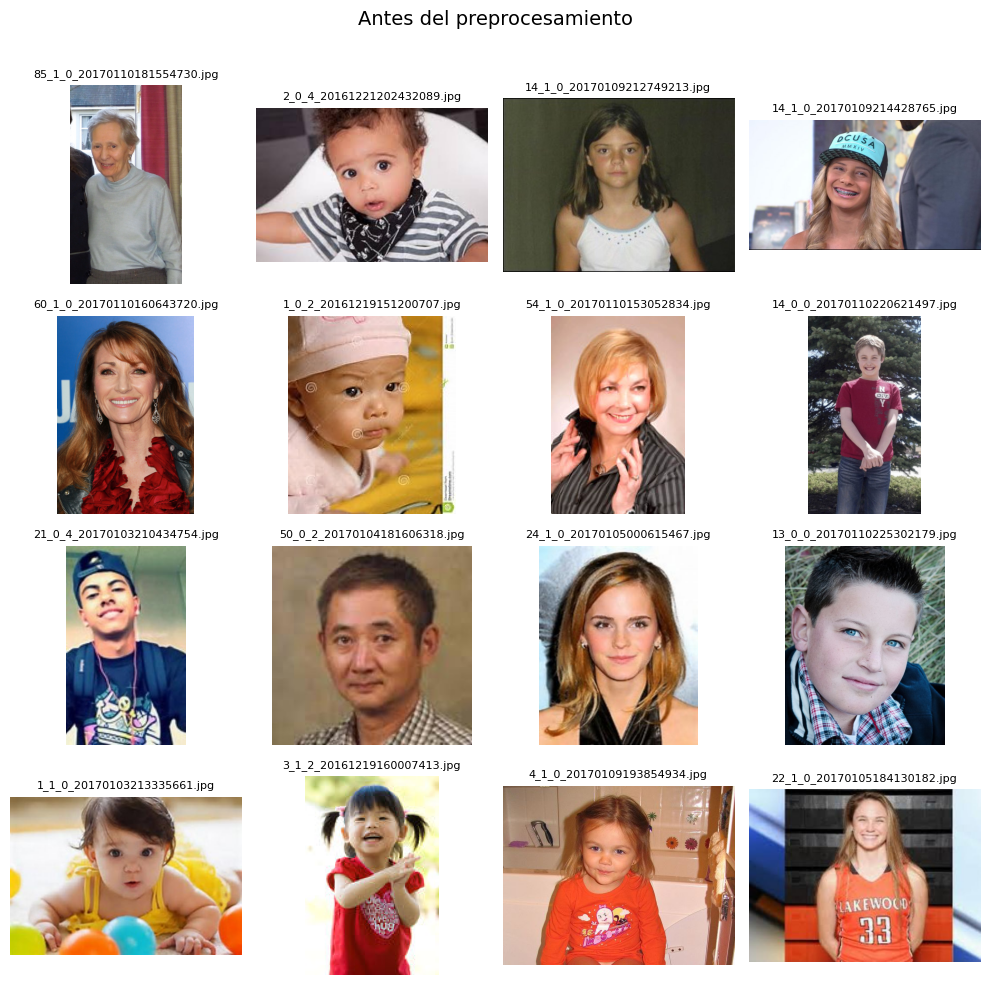

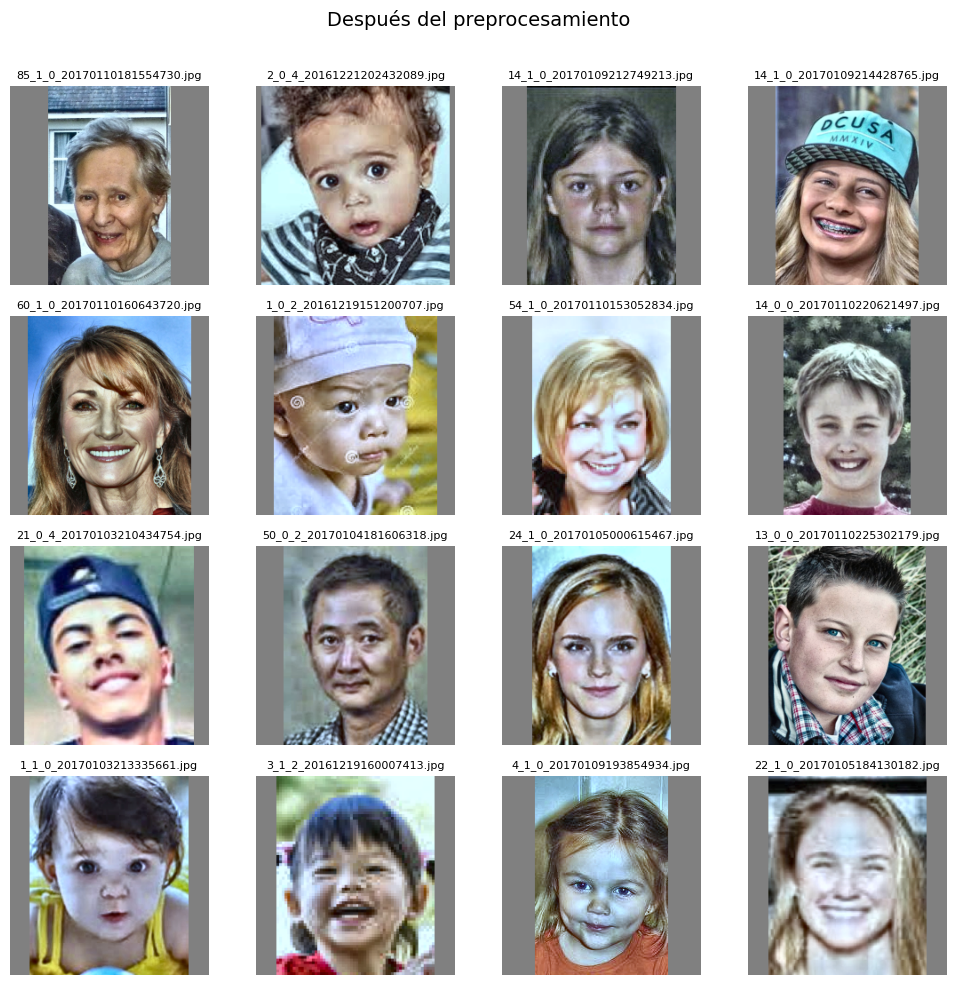

In [12]:
# Grid 4x4: ANTES
cols, rows = 4, 4
plt.figure(figsize=(10, 10))
for i, img_rgb in enumerate(originals_rgb):
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img_rgb)
    ax.set_title(kept_names[i], fontsize=8)
    ax.axis("off")
plt.suptitle("Antes del preprocesamiento", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Grid 4x4: DESPUÉS
plt.figure(figsize=(10, 10))
for i, img_rgb in enumerate(processed_rgb):
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img_rgb)
    ax.set_title(kept_names[i], fontsize=8)
    ax.axis("off")
plt.suptitle("Después del preprocesamiento", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### Entrenamiento del modelo

In [20]:
import os, re
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Config
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_DIR = "part1"   # ajusta si estás en Colab
IMG_SIZE    = 100       # igual que tu ejemplo; sube a 128 si quieres

# Regex robusto (match al inicio del nombre)
pat = re.compile(r'^(?P<age>\d{1,3})_(?P<gender>[01])_(?P<race>[0-4])_')

images, age_labels, gender_labels, race_labels = [], [], [], []

for fname in os.listdir(DATASET_DIR):
    m = pat.match(fname)
    if not m: 
        continue
    age   = int(m.group("age"))
    gen   = int(m.group("gender"))
    race  = int(m.group("race"))
    if not (0 <= age < 120):
        continue

    # Edad en 10 bins (0–9, 10–19, ..., 90+)
    age_group = min(age // 10, 9)

    p = os.path.join(DATASET_DIR, fname)
    img = cv2.imread(p)
    if img is None:
        continue
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0  # normalización simple

    images.append(img)
    age_labels.append(age_group)
    gender_labels.append(gen)
    race_labels.append(race)

# Arrays
X        = np.asarray(images, dtype=np.float32)
y_age    = to_categorical(age_labels,   num_classes=10)
y_gender = to_categorical(gender_labels, num_classes=2)
y_race   = to_categorical(race_labels,   num_classes=5)

print("X:", X.shape, "| y_age:", y_age.shape, "| y_gender:", y_gender.shape, "| y_race:", y_race.shape)


libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


X: (10135, 100, 100, 3) | y_age: (10135, 10) | y_gender: (10135, 2) | y_race: (10135, 5)


In [21]:
from tensorflow.keras import layers, models

def build_simple_mtl(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    age_out    = layers.Dense(10, activation='softmax', name='age')(x)
    gender_out = layers.Dense(2,  activation='softmax', name='gender')(x)
    race_out   = layers.Dense(5,  activation='softmax', name='race')(x)

    model = models.Model(inputs=inputs, outputs=[age_out, gender_out, race_out])
    model.compile(
        optimizer='adam',
        loss={'age':'categorical_crossentropy','gender':'categorical_crossentropy','race':'categorical_crossentropy'},
        metrics={'age':'accuracy','gender':'accuracy','race':'accuracy'}
    )
    return model

model = build_simple_mtl()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 25,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 10)        │      1,290 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 2)         │        258 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race (Dense)        │ (None, 5)         │        645 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,441 (372.82 KB)

 Trainable params: 95,441 (372.82 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Estratificación simple y robusta: genero_race_ageCoarse (10 bins -> 4 grupos)
age_bins_idx = np.asarray(age_labels, dtype=np.int32)  # ya es 0..9 (usado solo para coarse)
age_coarse   = (age_bins_idx // 3).astype(str)         # 0..3

strat_all = np.char.add(np.char.add(np.asarray(gender_labels).astype(str), "_"),
                        np.asarray(race_labels).astype(str))
strat_all = np.char.add(strat_all, "_"+age_coarse)

# 1) Test 10% fijo
idx_all = np.arange(len(X))
trainval_idx, test_idx = train_test_split(
    idx_all, test_size=0.10, random_state=SEED, stratify=strat_all
)

X_tv, X_test = X[trainval_idx], X[test_idx]
y_age_tv, y_age_test         = y_age[trainval_idx],    y_age[test_idx]
y_gender_tv, y_gender_test   = y_gender[trainval_idx], y_gender[test_idx]
y_race_tv, y_race_test       = y_race[trainval_idx],   y_race[test_idx]

age_tv   = age_bins_idx[trainval_idx]
gen_tv   = np.asarray(gender_labels)[trainval_idx]
race_tv  = np.asarray(race_labels)[trainval_idx]

print(f"Train+Val: {len(X_tv)} | Test: {len(X_test)}")
print("Porcentajes efectivos aprox.: Train 72% - Val 18% - Test 10%")

# 2) 5-fold CV en el 90%
strat_tv = np.char.add(np.char.add(gen_tv.astype(str), "_"), race_tv.astype(str))
strat_tv = np.char.add(strat_tv, "_"+(age_tv // 3).astype(str))

FOLDS  = 5
EPOCHS = 15
BATCH  = 64  # baja a 32 si te falta memoria

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

fold_hist = []
for fold, (tr_idx, va_idx) in enumerate(skf.split(X_tv, strat_tv), 1):
    print(f"\n===== Fold {fold}/{FOLDS} =====")

    X_tr, X_va = X_tv[tr_idx], X_tv[va_idx]
    y_age_tr,    y_age_va    = y_age_tv[tr_idx],    y_age_tv[va_idx]
    y_gender_tr, y_gender_va = y_gender_tv[tr_idx], y_gender_tv[va_idx]
    y_race_tr,   y_race_va   = y_race_tv[tr_idx],   y_race_tv[va_idx]

    model = build_simple_mtl()

    cbs = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ]

    history = model.fit(
        X_tr,
        [y_age_tr, y_gender_tr, y_race_tr],
        validation_data=(X_va, [y_age_va, y_gender_va, y_race_va]),
        epochs=EPOCHS,
        batch_size=BATCH,
        shuffle=True,
        verbose=1,
        callbacks=cbs
    )

    val_metrics = model.evaluate(X_va, [y_age_va, y_gender_va, y_race_va], verbose=0, return_dict=True)
    fold_hist.append(val_metrics)
    print("Val metrics:", val_metrics)

# Resumen CV
def mean_std(key):
    vals = [h[key] for h in fold_hist]
    return float(np.mean(vals)), float(np.std(vals))

print("\n===== Resumen CV (Validación) =====")
for k in fold_hist[0].keys():
    m, s = mean_std(k)
    print(f"{k}: mean={m:.4f}  std={s:.4f}")


Train+Val: 9121 | Test: 1014
Porcentajes efectivos aprox.: Train 72% - Val 18% - Test 10%

===== Fold 1/5 =====


/home/daniel_sanchez/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - age_accuracy: 0.2788 - age_loss: 2.0638 - gender_accuracy: 0.5105 - gender_loss: 0.7099 - loss: 4.1425 - race_accuracy: 0.5087 - race_loss: 1.3688 - val_age_accuracy: 0.3299 - val_age_loss: 1.9125 - val_gender_accuracy: 0.5688 - val_gender_loss: 0.6828 - val_loss: 3.8812 - val_race_accuracy: 0.5332 - val_race_loss: 1.2795 - learning_rate: 0.0010
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - age_accuracy: 0.3261 - age_loss: 1.9563 - gender_accuracy: 0.5298 - gender_loss: 0.6937 - loss: 3.9435 - race_accuracy: 0.5376 - race_loss: 1.2935 - val_age_accuracy: 0.3447 - val_age_loss: 1.8959 - val_gender_accuracy: 0.5600 - val_gender_loss: 0.6778 - val_loss: 3.8463 - val_race_accuracy: 0.5332 - val_race_loss: 1.2661 - learning_rate: 0.0010
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - age_accuracy: 0.3267 - age_loss: 1.9307 - gender_accuracy: 0.5414 - gender_loss: 0.6885 - loss: 3.9043 - race_accuracy: 0.5361 - race

In [23]:
# Entrena en todo el 90% y evalúa en el 10% reservado

final_model = build_simple_mtl()
cbs_final = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
]

# Usamos 10% del Train+Val como validación interna para monitoreo
X_tv_tr, X_tv_va, y_age_tr, y_age_va, y_gen_tr, y_gen_va, y_rac_tr, y_rac_va = train_test_split(
    X_tv, y_age_tv, y_gender_tv, y_race_tv,
    test_size=0.10, random_state=SEED, stratify=strat_tv
)

history_final = final_model.fit(
    X_tv_tr, [y_age_tr, y_gen_tr, y_rac_tr],
    validation_data=(X_tv_va, [y_age_va, y_gen_va, y_rac_va]),
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    verbose=1,
    callbacks=cbs_final
)

print("\n===== Evaluación en Test (10%) =====")
test_metrics = final_model.evaluate(X_test, [y_age_test, y_gender_test, y_race_test], verbose=1, return_dict=True)
print("Métricas en Test:", test_metrics)


Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - age_accuracy: 0.3001 - age_loss: 2.0506 - gender_accuracy: 0.5365 - gender_loss: 0.6925 - loss: 4.1045 - race_accuracy: 0.5267 - race_loss: 1.3614 - val_age_accuracy: 0.3308 - val_age_loss: 1.9265 - val_gender_accuracy: 0.5641 - val_gender_loss: 0.6749 - val_loss: 3.8662 - val_race_accuracy: 0.5334 - val_race_loss: 1.2586 - learning_rate: 0.0010
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - age_accuracy: 0.3231 - age_loss: 1.9528 - gender_accuracy: 0.5525 - gender_loss: 0.6839 - loss: 3.9363 - race_accuracy: 0.5262 - race_loss: 1.2996 - val_age_accuracy: 0.3330 - val_age_loss: 1.9252 - val_gender_accuracy: 0.5685 - val_gender_loss: 0.6725 - val_loss: 3.8662 - val_race_accuracy: 0.5323 - val_race_loss: 1.2617 - learning_rate: 0.0010
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - age_accuracy: 0.3313 - age_loss: 1.9385 - gender_accuracy: 0.5625 - gender_loss: 0.6793 - loss: 3.9006 - race_accuracy: 0.5282 - race

In [24]:
final_model.save("modelo25.h5")   # requiere h5py instalado (en Colab ya viene)
print("✅ Modelo guardado como modelo.h5")

✅ Modelo guardado como modelo.h5
